In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import mean_squared_error


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, Bidirectional,TimeDistributed,Conv1D,MaxPooling1D,Flatten,ConvLSTM2D,RepeatVector


#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [2]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('../input/pollution/pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution1.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


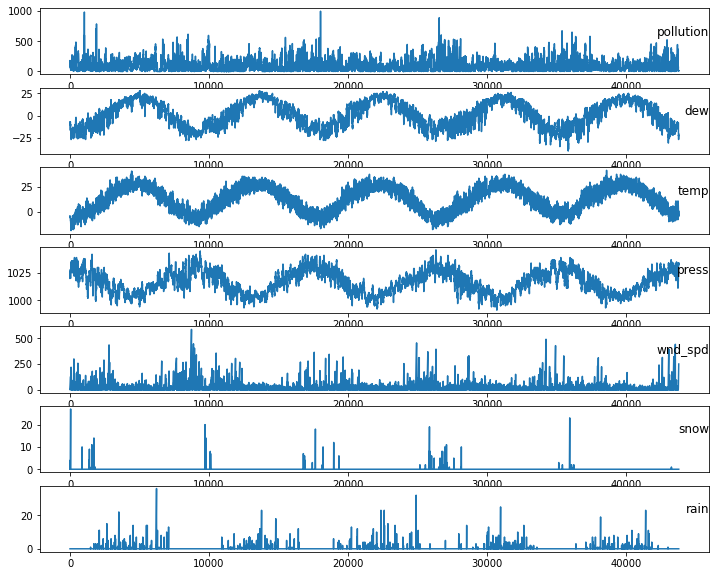

In [3]:
# load dataset
dataset = pd.read_csv('pollution1.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(12,10))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

## Multivariate LSTM Forecast Model

- We will frame the supervised learning problem as predicting the pollution at the current hour (t) given the pollution measurement and weather conditions at the prior time step

In [4]:
df = pd.DataFrame()
df['t'] = [x for x in range(10)]
df['t+1'] = df['t'].shift(-1)

df['t-1'] = df['t'].shift(1)
df['t-2'] = df['t'].shift(2)

print(df)

   t  t+1  t-1  t-2
0  0  1.0  NaN  NaN
1  1  2.0  0.0  NaN
2  2  3.0  1.0  0.0
3  3  4.0  2.0  1.0
4  4  5.0  3.0  2.0
5  5  6.0  4.0  3.0
6  6  7.0  5.0  4.0
7  7  8.0  6.0  5.0
8  8  9.0  7.0  6.0
9  9  NaN  8.0  7.0


In [5]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

values = [x for x in range(10)]
data = series_to_supervised(values,2,2)
print(data)

   var1(t-2)  var1(t-1)  var1(t)  var1(t+1)
2        0.0        1.0        2        3.0
3        1.0        2.0        3        4.0
4        2.0        3.0        4        5.0
5        3.0        4.0        5        6.0
6        4.0        5.0        6        7.0
7        5.0        6.0        7        8.0
8        6.0        7.0        8        9.0


In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


raw = DataFrame()
raw['ob1'] = [x for x in range(10)]
raw['ob2'] = [x for x in range(50, 60)]
values = raw.values
data = series_to_supervised(values,2,1)
print(data)

   var1(t-2)  var2(t-2)  var1(t-1)  var2(t-1)  var1(t)  var2(t)
2        0.0       50.0        1.0       51.0        2       52
3        1.0       51.0        2.0       52.0        3       53
4        2.0       52.0        3.0       53.0        4       54
5        3.0       53.0        4.0       54.0        5       55
6        4.0       54.0        5.0       55.0        6       56
7        5.0       55.0        6.0       56.0        7       57
8        6.0       56.0        7.0       57.0        8       58
9        7.0       57.0        8.0       58.0        9       59


## LSTM Data Preparation

In [7]:


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = pd.read_csv('pollution1.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


### Define and Fit Model

- We will fit the model on the 4 year of data, then evaluate it on the remaining 1 year of data. 

In [23]:
# split into train and test sets
values = reframed.values
print(values.shape)
n_train_hours = 4*365 * 24 # 4 years data
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(43799, 9)
(35040, 1, 8) (35040,) (8759, 1, 8) (8759,)


In [24]:
input_shape=(test_X.shape[0], test_X.shape[2])
input_shape

(8759, 8)

- We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. 
- The input shape will be 1 time step with 8 features.
- We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.
- The model will be fit for 50 training epochs with a batch size of 72.
- Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function.

Epoch 1/50
487/487 - 4s - loss: 0.0330 - val_loss: 0.0360
Epoch 2/50
487/487 - 2s - loss: 0.0145 - val_loss: 0.0151
Epoch 3/50
487/487 - 2s - loss: 0.0141 - val_loss: 0.0131
Epoch 4/50
487/487 - 2s - loss: 0.0140 - val_loss: 0.0130
Epoch 5/50
487/487 - 2s - loss: 0.0141 - val_loss: 0.0131
Epoch 6/50
487/487 - 2s - loss: 0.0140 - val_loss: 0.0132
Epoch 7/50
487/487 - 2s - loss: 0.0140 - val_loss: 0.0132
Epoch 8/50
487/487 - 2s - loss: 0.0139 - val_loss: 0.0132
Epoch 9/50
487/487 - 2s - loss: 0.0140 - val_loss: 0.0132
Epoch 10/50
487/487 - 2s - loss: 0.0139 - val_loss: 0.0132
Epoch 11/50
487/487 - 2s - loss: 0.0139 - val_loss: 0.0132
Epoch 12/50
487/487 - 2s - loss: 0.0139 - val_loss: 0.0132
Epoch 13/50
487/487 - 3s - loss: 0.0139 - val_loss: 0.0133
Epoch 14/50
487/487 - 2s - loss: 0.0139 - val_loss: 0.0134
Epoch 15/50
487/487 - 2s - loss: 0.0138 - val_loss: 0.0135
Epoch 16/50
487/487 - 2s - loss: 0.0138 - val_loss: 0.0134
Epoch 17/50
487/487 - 2s - loss: 0.0138 - val_loss: 0.0135
Epoch 

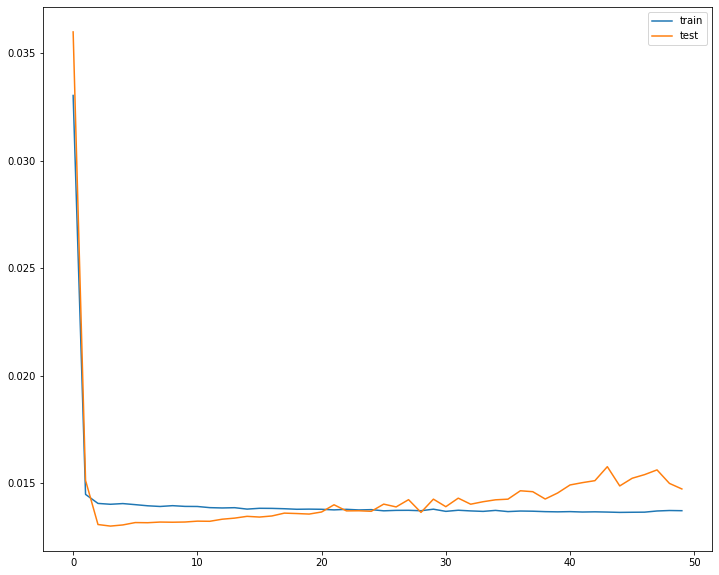

In [12]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.figure(figsize=(12,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [25]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.139


- We can see that the model achieves a respectable RMSE of 26.139, which is lower than an RMSE of 30 found with a persistence model.

(43797, 32)
(35040, 24) 35040 (35040,)
(35040, 3, 8) (35040,) (8757, 3, 8) (8757,)
Epoch 1/50
487/487 - 7s - loss: 0.0309 - val_loss: 0.0286
Epoch 2/50
487/487 - 3s - loss: 0.0208 - val_loss: 0.0241
Epoch 3/50
487/487 - 3s - loss: 0.0168 - val_loss: 0.0200
Epoch 4/50
487/487 - 3s - loss: 0.0146 - val_loss: 0.0187
Epoch 5/50
487/487 - 3s - loss: 0.0143 - val_loss: 0.0183
Epoch 6/50
487/487 - 3s - loss: 0.0140 - val_loss: 0.0171
Epoch 7/50
487/487 - 3s - loss: 0.0140 - val_loss: 0.0166
Epoch 8/50
487/487 - 3s - loss: 0.0140 - val_loss: 0.0164
Epoch 9/50
487/487 - 4s - loss: 0.0139 - val_loss: 0.0165
Epoch 10/50
487/487 - 3s - loss: 0.0138 - val_loss: 0.0164
Epoch 11/50
487/487 - 3s - loss: 0.0138 - val_loss: 0.0167
Epoch 12/50
487/487 - 3s - loss: 0.0139 - val_loss: 0.0173
Epoch 13/50
487/487 - 3s - loss: 0.0139 - val_loss: 0.0170
Epoch 14/50
487/487 - 3s - loss: 0.0139 - val_loss: 0.0162
Epoch 15/50
487/487 - 3s - loss: 0.0137 - val_loss: 0.0166
Epoch 16/50
487/487 - 3s - loss: 0.0136 -

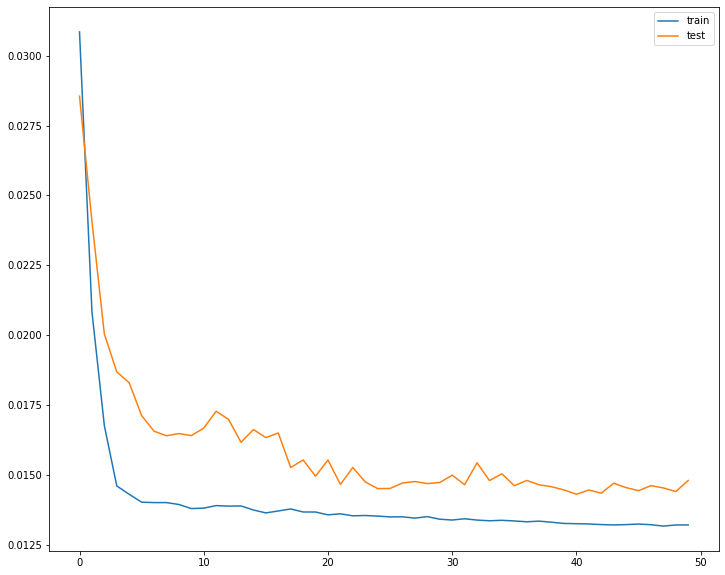

Test RMSE: 25.737


In [29]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = pd.read_csv('pollution1.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_hours = 4*365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.figure(figsize=(12,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

- - We can see that the model achieves a respectable RMSE of 25.737, which is lower than an RMSE of 30 found with a persistence model.